In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

# Data Loading

In [2]:
data = pd.read_csv('Bike Data.csv')

In [3]:
# Display basic information about the dataset
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
data.info()

Dataset Head:
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  

Dataset Inf

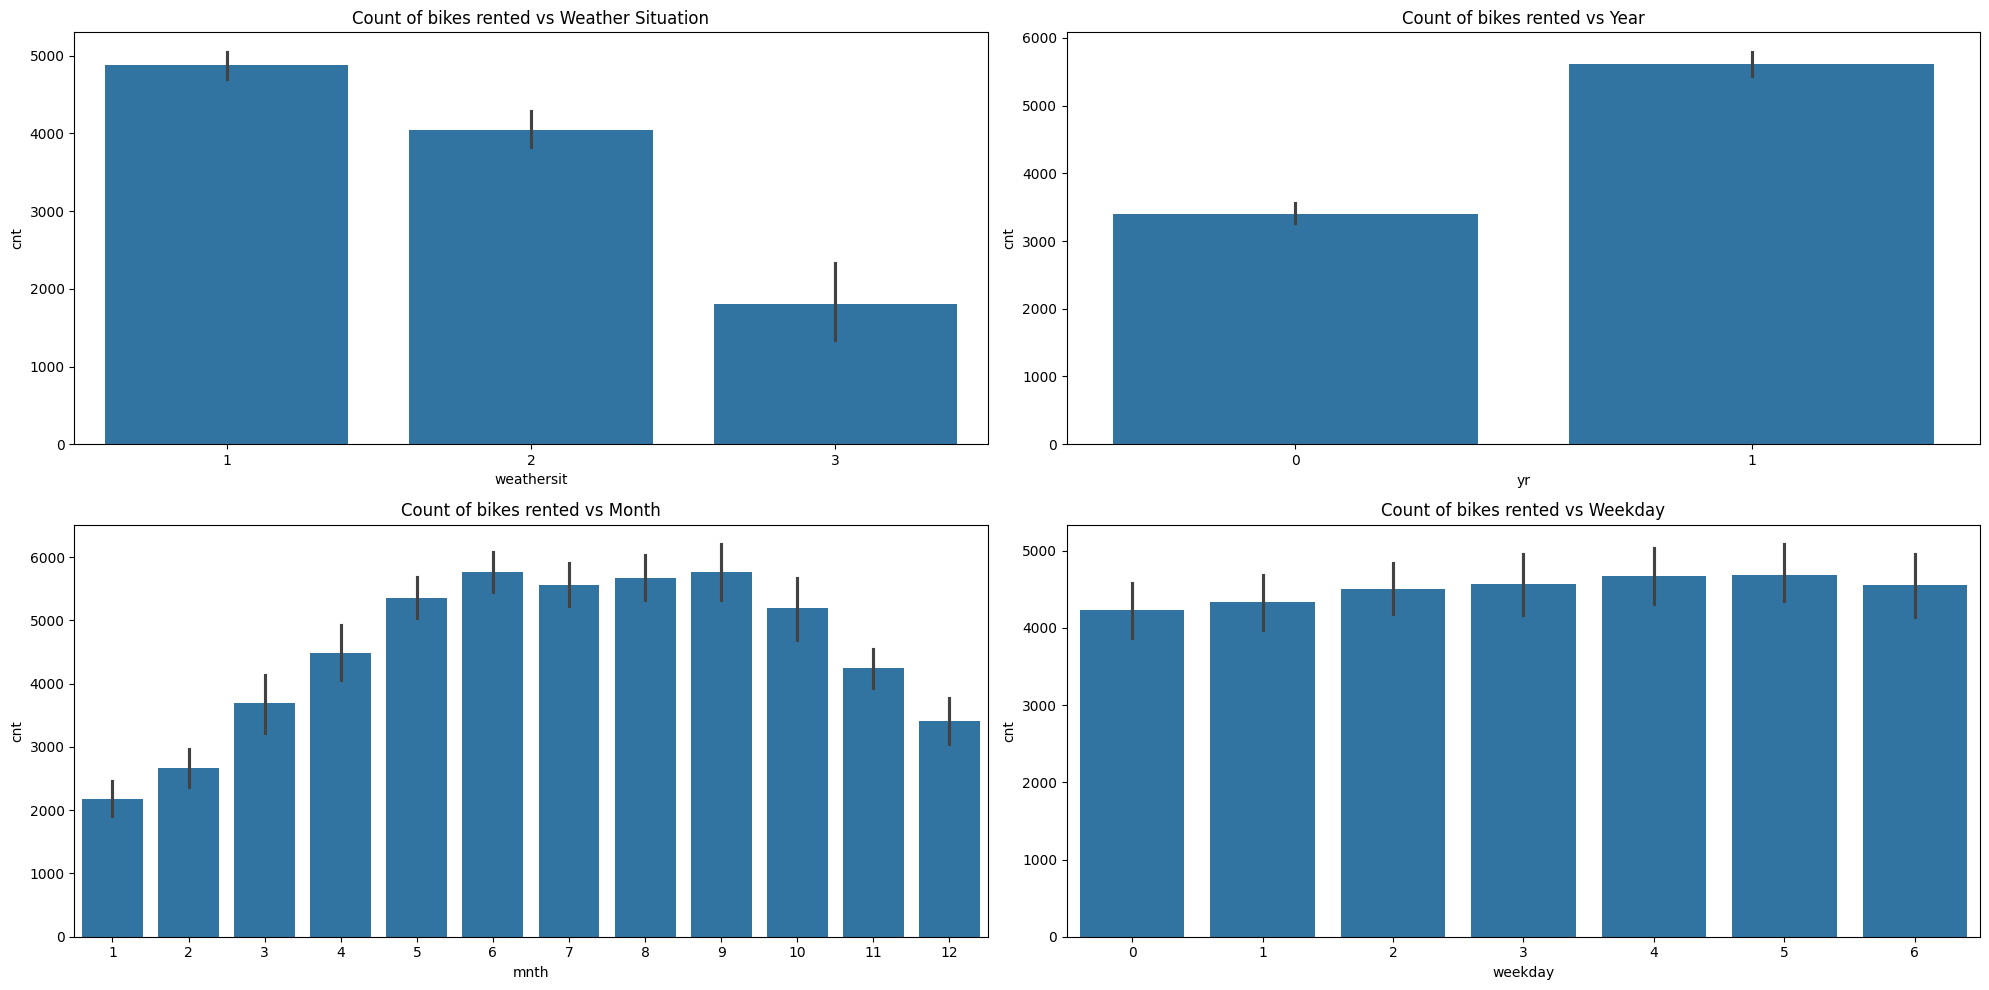

In [4]:
#Visualization of data
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
sns.barplot(x='weathersit', y='cnt', data=data)
plt.title('Count of bikes rented vs Weather Situation')

plt.subplot(2, 2, 2)
sns.barplot(x='yr', y='cnt', data=data)
plt.title('Count of bikes rented vs Year')

plt.subplot(2, 2, 3)
sns.barplot(x='mnth', y='cnt', data=data)
plt.title('Count of bikes rented vs Month')

plt.subplot(2, 2, 4)
sns.barplot(x='weekday', y='cnt', data=data)
plt.title('Count of bikes rented vs Weekday')

plt.tight_layout()
plt.show()

# Pre-Processing

In [5]:
# Drop columns 'casual' and 'registered'
data = data.drop(columns=['instant', 'dteday', 'casual', 'registered'])

In [6]:
# Map categorical variables based on the data dictionary
data['season'] = data['season'].map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
data['weathersit'] = data['weathersit'].map({
    1: "Clear, Few clouds, Partly cloudy, Partly cloudy",
    2: "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",
    3: "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",
    4: "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"
})
data['yr'] = data['yr'].map({0: 2018, 1: 2019})
data['weekday'] = data['weekday'].map({
    1: 'Wednesday', 2: 'Thursday', 3: 'Friday', 4: 'Satday', 5: 'Sunday', 6: 'Monday', 0: 'Tuesday'
})

In [7]:
# Convert categorical variables to dummy variables
data = pd.get_dummies(data, columns=['season', 'weathersit', 'yr', 'weekday', 'mnth'], drop_first=True)

# Exploratory Data Analysis (EDA)

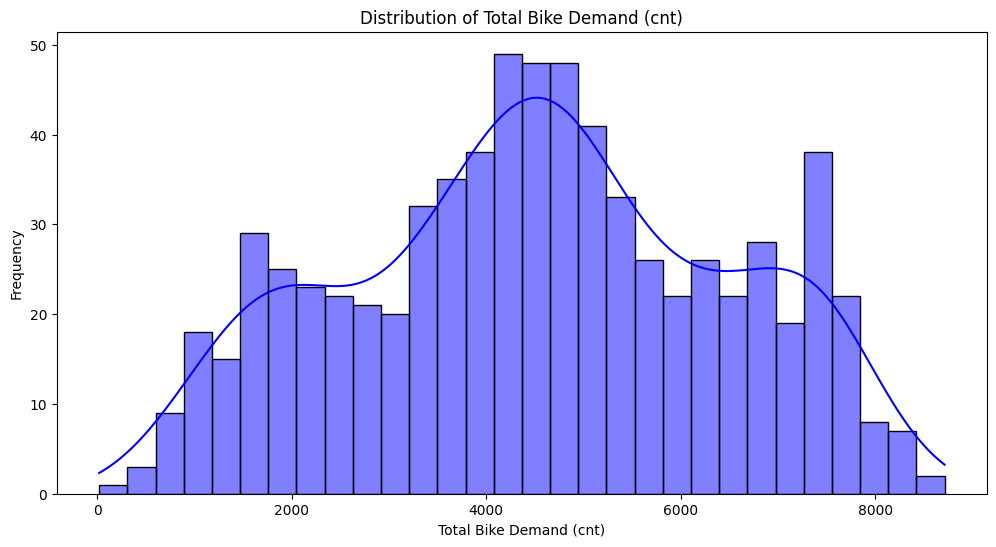

In [8]:
# Univariate Analysis
plt.figure(figsize=(12, 6))
sns.histplot(data['cnt'], kde=True, bins=30, color='blue')
plt.title('Distribution of Total Bike Demand (cnt)')
plt.xlabel('Total Bike Demand (cnt)')
plt.ylabel('Frequency')
plt.show()

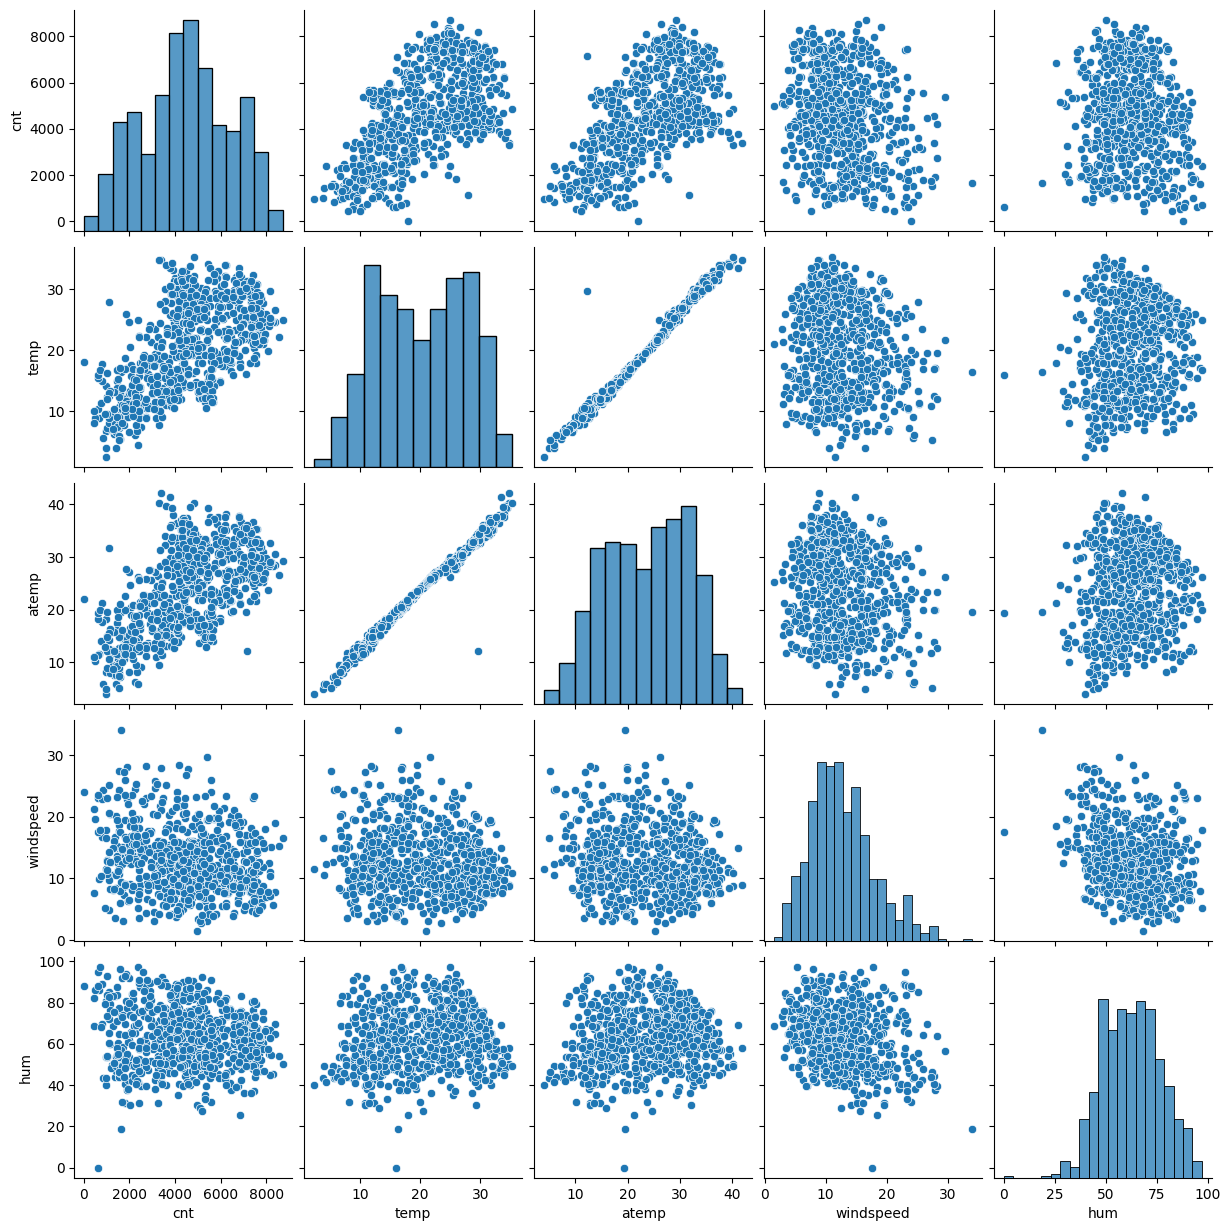

In [9]:
sns.pairplot(data = data, vars=['cnt', 'temp', 'atemp', 'windspeed', 'hum'])
plt.show()

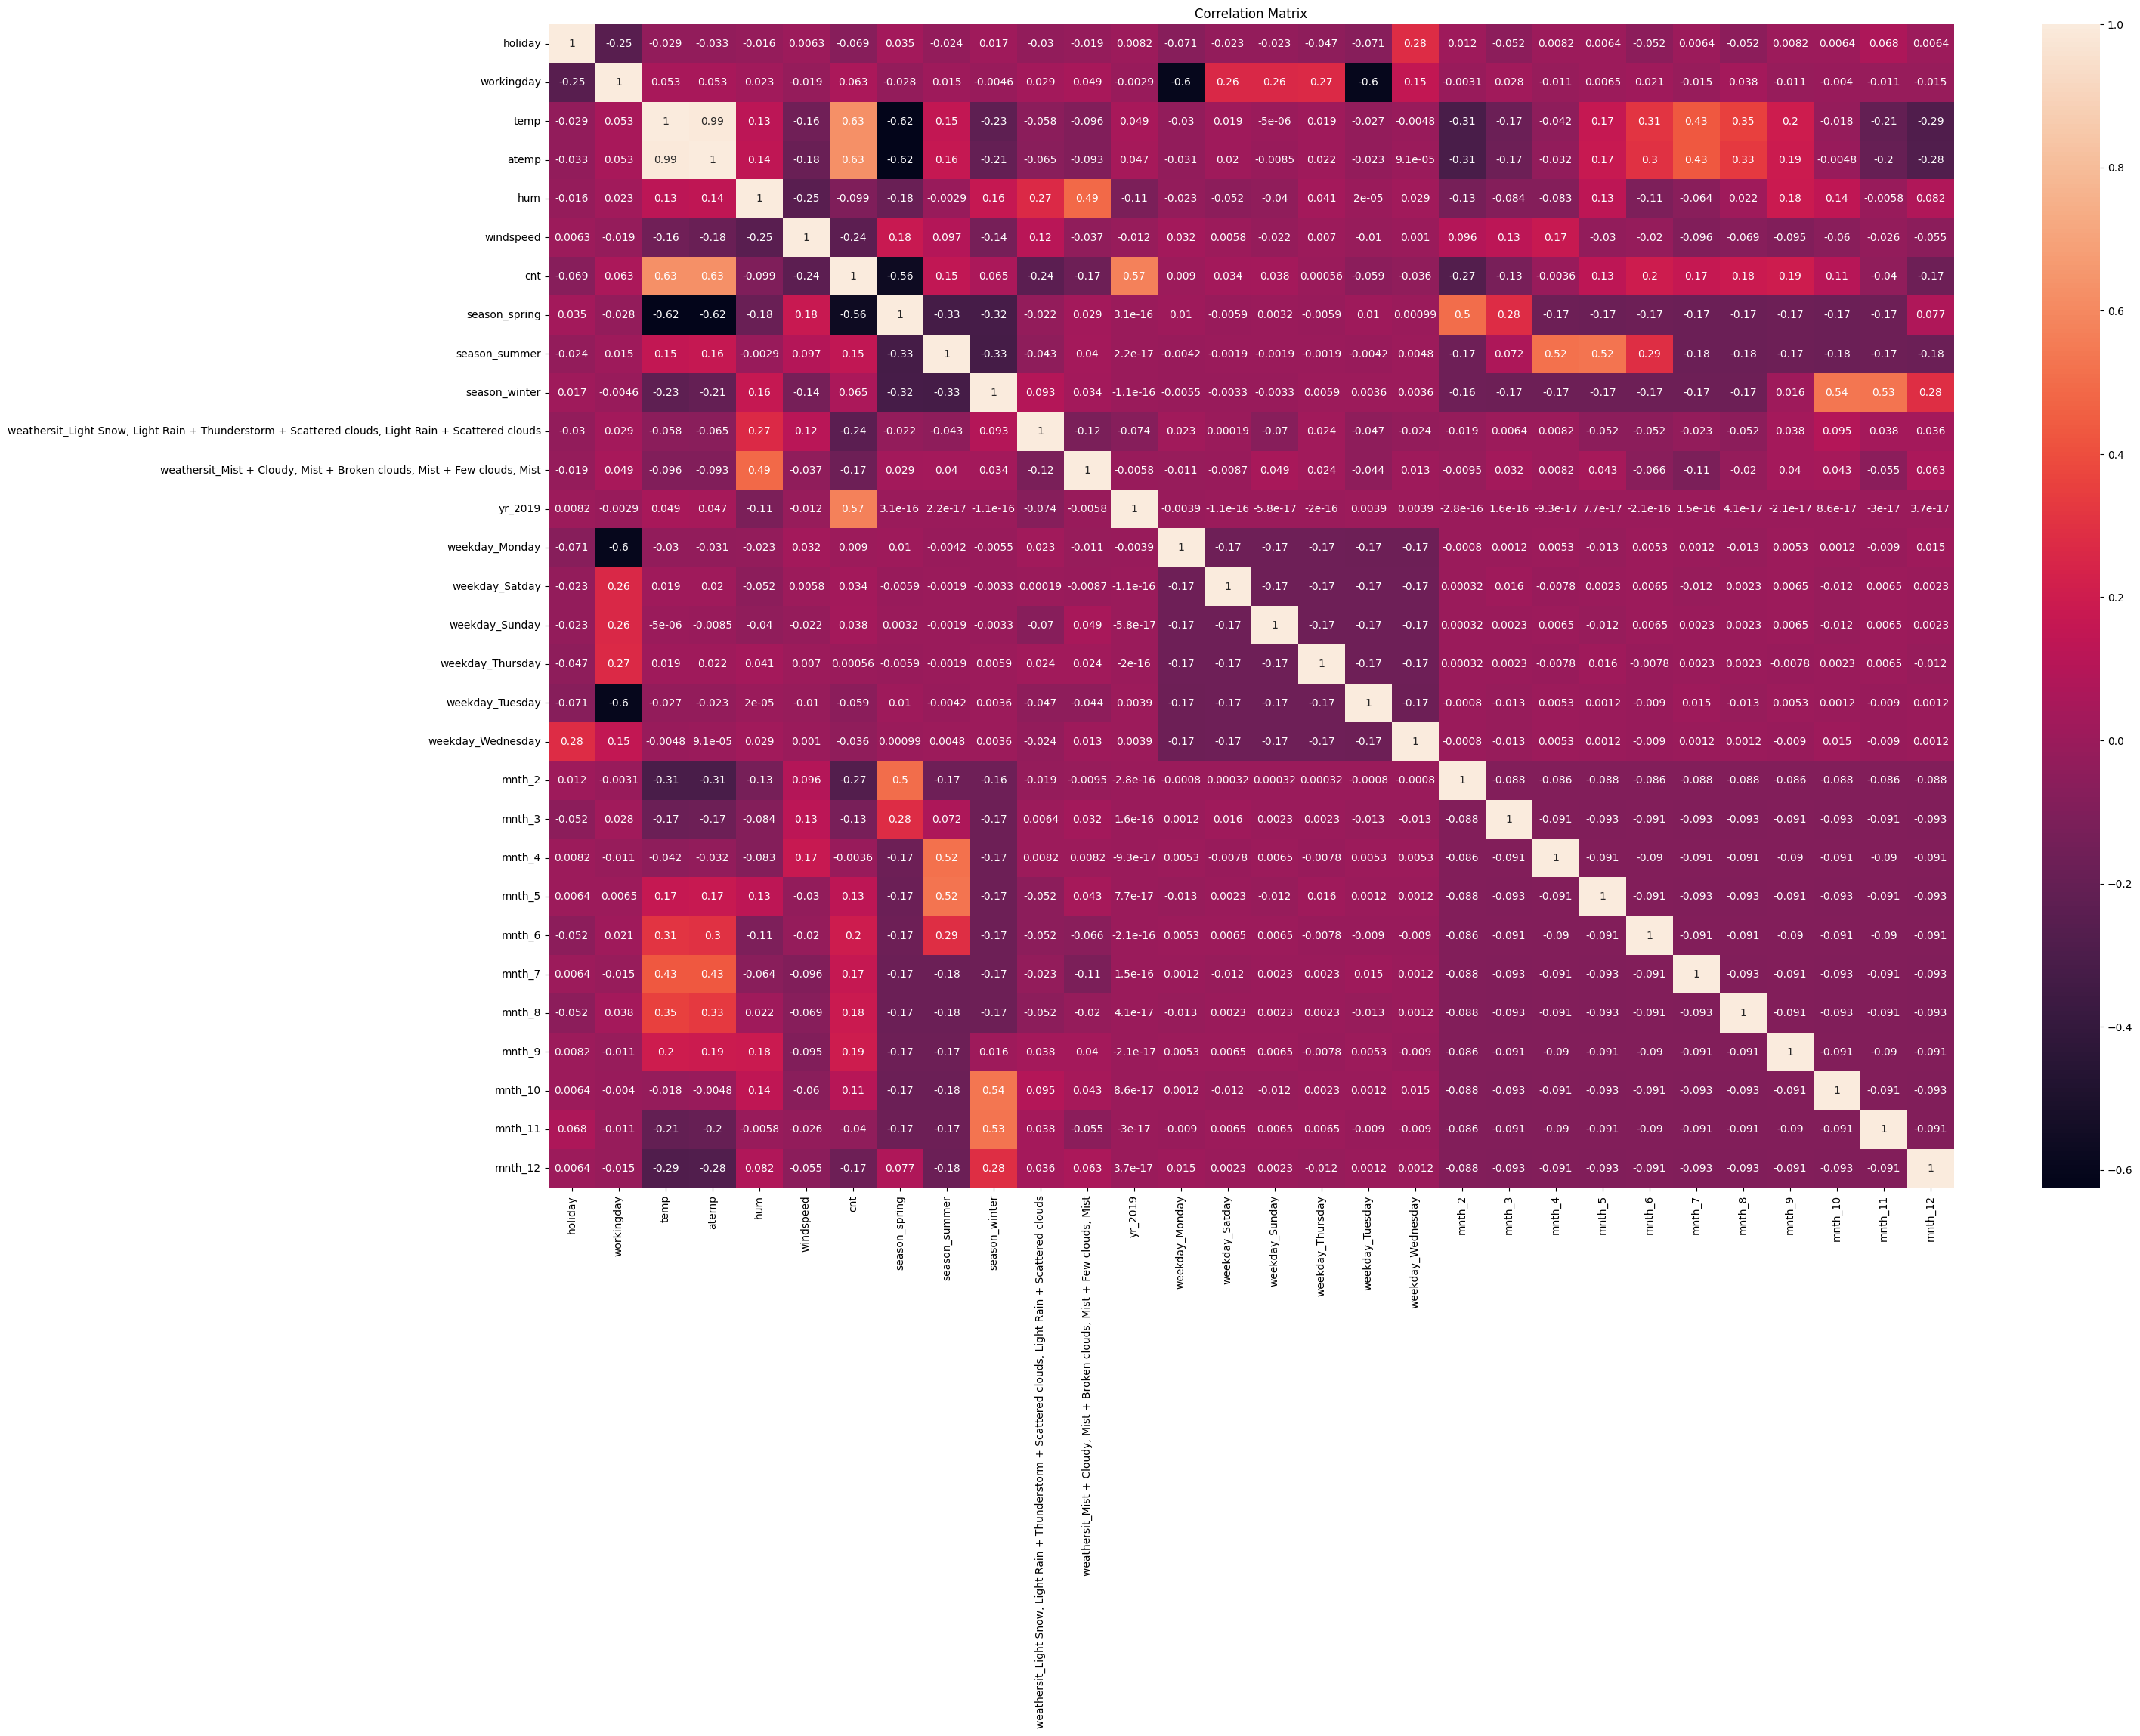

In [10]:
# Correlation Matrix
plt.figure(figsize=(30, 20))
sns.heatmap(data.corr(), annot=True)
plt.title('Correlation Matrix')
plt.show()

# Train-Test Split

In [11]:
X = data.drop(columns=['cnt'])  # Remove irrelevant columns
y = data['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#RFE and Model Building

In [13]:
lr = LinearRegression()
n_features_to_select = int(len(X_train.columns) * 0.5)
rfe = RFE(lr, n_features_to_select=n_features_to_select)
rfe.fit(X_train_scaled, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=14)

In [14]:
# Selected Features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['temp', 'atemp', 'hum', 'windspeed', 'season_spring', 'season_winter',
       'weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'yr_2019', 'weekday_Tuesday', 'mnth_7', 'mnth_9', 'mnth_11', 'mnth_12'],
      dtype='object')


In [15]:
# Build model with selected features
X_train_selected = X_train_scaled[:, rfe.support_]
X_test_selected = X_test_scaled[:, rfe.support_]

#Check Summary

In [16]:
# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train_selected)
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     203.7
Date:                Sun, 26 Jan 2025   Prob (F-statistic):          6.60e-211
Time:                        13:29:26   Log-Likelihood:                -4730.1
No. Observations:                 584   AIC:                             9490.
Df Residuals:                     569   BIC:                             9556.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4546.3613     33.401    136.114      0.0

#Check VIF

In [17]:
vif_data = pd.DataFrame()
vif_data['Feature'] = selected_features
vif_data['VIF'] = [variance_inflation_factor(X_train_selected, i) for i in range(X_train_selected.shape[1])]
print("\nVIF Data:")
print(vif_data)


VIF Data:
                                              Feature         VIF
0                                                temp  176.161603
1                                               atemp  175.839741
2                                                 hum    1.966000
3                                           windspeed    1.250270
4                                       season_spring    2.810448
5                                       season_winter    2.237508
6   weathersit_Light Snow, Light Rain + Thundersto...    1.358158
7   weathersit_Mist + Cloudy, Mist + Broken clouds...    1.606534
8                                             yr_2019    1.037781
9                                     weekday_Tuesday    1.013763
10                                             mnth_7    1.371653
11                                             mnth_9    1.146667
12                                            mnth_11    1.674028
13                                            mnth_12    1.298762

In [18]:
# Removing features
high_vif_features = ['atemp']

selected_features = [f for f in selected_features if f not in high_vif_features]
print("Updated Selected Features:", selected_features)

Updated Selected Features: ['temp', 'hum', 'windspeed', 'season_spring', 'season_winter', 'weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 'weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', 'yr_2019', 'weekday_Tuesday', 'mnth_7', 'mnth_9', 'mnth_11', 'mnth_12']


In [19]:
# Update features
X_train_selected = X_train[X_train.columns.intersection(selected_features)].values
X_test_selected = X_test[X_test.columns.intersection(selected_features)].values

In [20]:
X_train_selected = np.asarray(X_train_selected, dtype=float)
X_test_selected = np.asarray(X_test_selected, dtype=float)

In [21]:
# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train_selected)
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     218.6
Date:                Sun, 26 Jan 2025   Prob (F-statistic):          1.49e-211
Time:                        13:29:26   Log-Likelihood:                -4731.4
No. Observations:                 584   AIC:                             9491.
Df Residuals:                     570   BIC:                             9552.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3219.1841    298.806     10.773      0.0

In [22]:
# Re-check VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = selected_features
vif_data['VIF'] = [variance_inflation_factor(X_train_selected, i) for i in range(X_train_selected.shape[1])]
print("\nRe-Checked VIF Data:")
print(vif_data)


Re-Checked VIF Data:
                                              Feature        VIF
0                                                temp  19.603266
1                                                 hum  26.292023
2                                           windspeed   6.044825
3                                       season_spring   2.494159
4                                       season_winter   2.763783
5   weathersit_Light Snow, Light Rain + Thundersto...   1.295639
6   weathersit_Mist + Cloudy, Mist + Broken clouds...   2.284017
7                                             yr_2019   2.075707
8                                     weekday_Tuesday   1.191887
9                                              mnth_7   1.496367
10                                             mnth_9   1.224114
11                                            mnth_11   1.771743
12                                            mnth_12   1.387627


In [23]:
# Removing features
high_vif_features = ['hum']

selected_features = [f for f in selected_features if f not in high_vif_features]
print("Updated Selected Features:", selected_features)

Updated Selected Features: ['temp', 'windspeed', 'season_spring', 'season_winter', 'weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 'weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', 'yr_2019', 'weekday_Tuesday', 'mnth_7', 'mnth_9', 'mnth_11', 'mnth_12']


In [24]:
# Update features
X_train_selected = X_train[X_train.columns.intersection(selected_features)].values
X_test_selected = X_test[X_test.columns.intersection(selected_features)].values

In [25]:
X_train_selected = np.asarray(X_train_selected, dtype=float)
X_test_selected = np.asarray(X_test_selected, dtype=float)

In [26]:
# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train_selected)
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     228.2
Date:                Sun, 26 Jan 2025   Prob (F-statistic):          8.57e-209
Time:                        13:29:26   Log-Likelihood:                -4740.7
No. Observations:                 584   AIC:                             9507.
Df Residuals:                     571   BIC:                             9564.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2460.0174    244.966     10.042      0.0

In [27]:
# Re-check VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = selected_features
vif_data['VIF'] = [variance_inflation_factor(X_train_selected, i) for i in range(X_train_selected.shape[1])]
print("\nRe-Checked VIF Data:")
print(vif_data)


Re-Checked VIF Data:
                                              Feature       VIF
0                                                temp  6.394853
1                                           windspeed  6.006836
2                                       season_spring  1.713731
3                                       season_winter  2.399723
4   weathersit_Light Snow, Light Rain + Thundersto...  1.107595
5   weathersit_Mist + Cloudy, Mist + Broken clouds...  1.562563
6                                             yr_2019  2.064712
7                                     weekday_Tuesday  1.185632
8                                              mnth_7  1.433439
9                                              mnth_9  1.217012
10                                            mnth_11  1.740550
11                                            mnth_12  1.333706


In [28]:
# Removing features
high_vif_features = ['windspeed']

selected_features = [f for f in selected_features if f not in high_vif_features]
print("Updated Selected Features:", selected_features)

Updated Selected Features: ['temp', 'season_spring', 'season_winter', 'weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 'weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', 'yr_2019', 'weekday_Tuesday', 'mnth_7', 'mnth_9', 'mnth_11', 'mnth_12']


In [29]:
# Update features
X_train_selected = X_train[X_train.columns.intersection(selected_features)].values
X_test_selected = X_test[X_test.columns.intersection(selected_features)].values

In [30]:
X_train_selected = np.asarray(X_train_selected, dtype=float)
X_test_selected = np.asarray(X_test_selected, dtype=float)

In [31]:
# Add constant for statsmodels
X_train_sm = sm.add_constant(X_train_selected)
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     236.3
Date:                Sun, 26 Jan 2025   Prob (F-statistic):          1.76e-204
Time:                        13:29:27   Log-Likelihood:                -4753.7
No. Observations:                 584   AIC:                             9531.
Df Residuals:                     572   BIC:                             9584.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1845.6110    217.960      8.468      0.0

In [32]:
# Re-check VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = selected_features
vif_data['VIF'] = [variance_inflation_factor(X_train_selected, i) for i in range(X_train_selected.shape[1])]
print("\nRe-Checked VIF Data:")
print(vif_data)


Re-Checked VIF Data:
                                              Feature       VIF
0                                                temp  3.200542
1                                       season_spring  1.325155
2                                       season_winter  2.388610
3   weathersit_Light Snow, Light Rain + Thundersto...  1.067005
4   weathersit_Mist + Cloudy, Mist + Broken clouds...  1.546887
5                                             yr_2019  2.060387
6                                     weekday_Tuesday  1.177520
7                                              mnth_7  1.391186
8                                              mnth_9  1.207728
9                                             mnth_11  1.706010
10                                            mnth_12  1.332877


#Evaluate the Model

In [33]:
# Predictions
X_test_sm = sm.add_constant(X_test_selected)
y_pred = model.predict(X_test_sm)

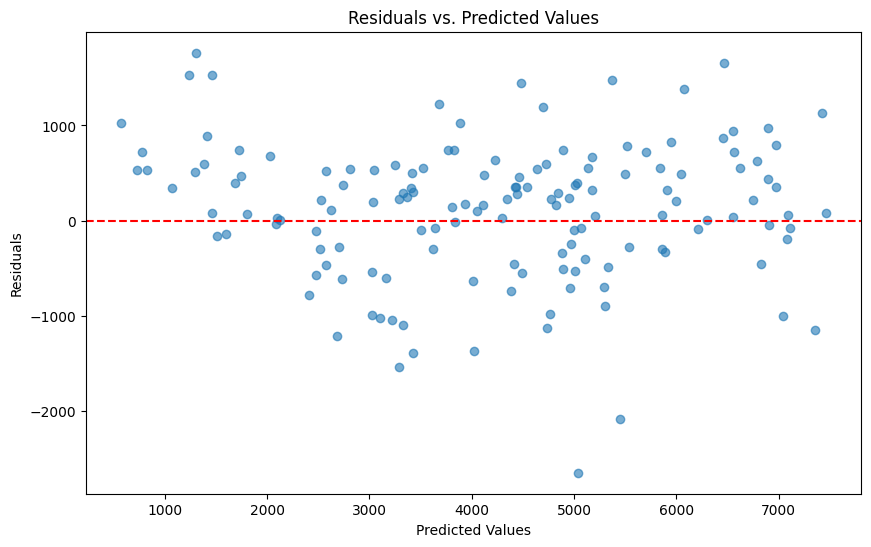

In [34]:
# Calculate residuals
residuals = y_test - y_pred

# Residuals vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values")
plt.show()

In [35]:
# R2 and RMSE
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [36]:
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

R2 Score: 0.8454
RMSE: 727.55
